<div align="right">Python 2.7 Jupyter Notebook</div>

# Network Analysis Exercises Using 'Friends and Family' Dataset 

<br><div class="alert alert-warning">
<b>Note that this notebook contains advanced exercises applicable only to students who wish to deepen their understanding and qualify for bonus marks as part of the technical track.</b> You will be able to achieve 100% for this notebook by only completing exercise 1. Optional advanced exercises can be completed to qualify for bonus marks.
</div>

## Part 2: Clustering

### Your completion of the notebook exercises will be graded based on your ability to:

> **Understand**: Does your pseudo-code and/or comments show evidence that you recall and understand technical concepts?

> **Apply**: Are you able to execute code, using the supplied examples, that perform the required functionality on supplied or generated data sets? 

> **Analyze**: Are you able to pick the relevant method, library or resolve specific stated questions?

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?

# Notebook introduction

Community detection is an important task in social network analysis. The idea behind it is to identify groups of people that share a common interest, based on the assumption that these people tend to link to each other more often than to the rest of the network. Specifically, real-world networks exhibit clustering behavior that can be observed in the graph representation (of these networks) by the formation of clusters or partitions. These groups of nodes on a graph (clusters) correspond to communities that share common properties, or have a common role in the system under study.

Intuitively, it is expected that such clusters are associated with a high concentration of nodes. In the following examples, you will explore the identification of these clusters using the following approaches as discussed in the video lectures:

1. Hierarchical clustering (using a distance matrix);
2. The Louvain Algorithm (using modularity maximization); and
3. Spectral graph partitioning.

<br>
<div class="alert alert-warning">
<b>Some students experienced issues with the incorrect versions of sklearn and scipy modules on their environments.</b><br>The code cells below will remove and reinstall these modules. The first cell may produce errors depending on the current state of your virtual analysis environment. It is important that the second cell completes successfully. It should state "Successfully installed scipy" and "Successfully installed scikit-learn" in the output.
</div>

In [1]:
# Uninstall existing broken installs.
!sudo /usr/bin/yes | pip uninstall scikit-learn
!sudo /usr/bin/yes | pip uninstall scipy

Uninstalling scikit-learn-0.17.1:
  /home/ubuntu/.local/lib/python2.7/site-packages/scikit_learn-0.17.1.dist-info/DESCRIPTION.rst
  /home/ubuntu/.local/lib/python2.7/site-packages/scikit_learn-0.17.1.dist-info/INSTALLER
  /home/ubuntu/.local/lib/python2.7/site-packages/scikit_learn-0.17.1.dist-info/METADATA
  /home/ubuntu/.local/lib/python2.7/site-packages/scikit_learn-0.17.1.dist-info/RECORD
  /home/ubuntu/.local/lib/python2.7/site-packages/scikit_learn-0.17.1.dist-info/WHEEL
  /home/ubuntu/.local/lib/python2.7/site-packages/scikit_learn-0.17.1.dist-info/metadata.json
  /home/ubuntu/.local/lib/python2.7/site-packages/scikit_learn-0.17.1.dist-info/top_level.txt
  /home/ubuntu/.local/lib/python2.7/site-packages/sklearn/.libs/libgfortran-ed201abd.so.3.0.0
  /home/ubuntu/.local/lib/python2.7/site-packages/sklearn/.libs/libopenblasp-r0-39a31c03.2.18.so
  /home/ubuntu/.local/lib/python2.7/site-packages/sklearn/__check_build/__init__.py
  /home/ubuntu/.local/lib/python2.7/site-packages/sklea

In [2]:
# Reinstall to sklearn and scipy.
!pip install scipy --target=/home/ubuntu/.local/lib/python2.7/site-packages
!pip install scikit-learn --target=/home/ubuntu/.local/lib/python2.7/site-packages

  Using cached scipy-0.18.0-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached scikit_learn-0.17.1-cp27-cp27mu-manylinux1_x86_64.whl


You can now continue with the remainder of the notebook.

#### Import required modules

In [3]:
import networkx as nx
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

from collections import defaultdict, Counter
import operator

## For hierarchical clustering.
from scipy.cluster import hierarchy
from scipy.spatial import distance

## For spectral graph partitioning.
from sklearn.cluster import spectral_clustering as spc

## For Community Detection (Louvain Method).
import community

import sys
sys.path.append('..')
from utils import draw_partitioned_graph

plt.rcParams['figure.figsize'] = (15, 9)
plt.rcParams['axes.titlesize'] = 'large'

## 1. Data preparation

You are going to read the graph from an adjacency list saved in the earlier exercises.

In [4]:
call_adjmatrix = pd.read_csv('./call.adjmatrix', index_col=0)
call_graph     = nx.from_numpy_matrix(call_adjmatrix.as_matrix())

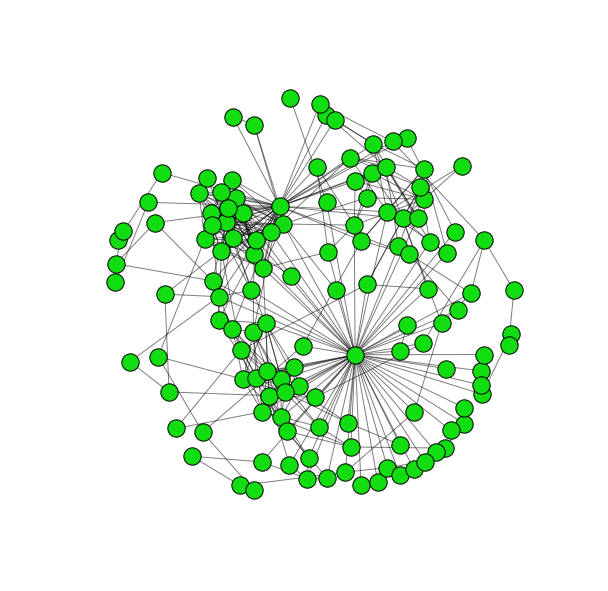

In [5]:
# Display call graph object.
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(call_graph)

nx.draw_networkx_nodes(call_graph, pos=pos, node_color='#11DD11')
nx.draw_networkx_edges(call_graph, pos=pos, alpha=0.5)
plt.show()

## 2. Hierarchical clustering

This notebook will make use of a hierarchical clustering algorithm as implemented in [Scipy](http://docs.scipy.org/doc/scipy/reference/). The following example uses the average distance measure. Since the graph is weighted, you can also use the single linkage inter-cluster distance measure (see exercises).

In [6]:
def create_hc(G, t=3, linkage='max'):
    """
    Creates hierarchical cluster of graph G from distance matrix
    
    'Erika Fille Legara <legareft@ihpc.a-star.edu.sg>',
    'Maksim Tsvetovat <maksim@tsvetovat.org',
    'Drew Conway <drew.conway@nyu.edu>',
    'Aric Hagberg <hagberg@lanl.gov>'
    'Gorden Jemwa <>' : modifications: set t argument with default, 
                                       accept linkage with default as an argument
    """
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((len(G),len(G)))
    labels=G.nodes() # keep node labels.
    for u,p in path_length.items():
        for v,d in p.items():
            #distances[u][v]=d
            distances[G.nodes().index(u)][G.nodes().index(v)] = d
            distances[G.nodes().index(v)][G.nodes().index(u)] = d
            if u==v: distances[G.nodes().index(u)][G.nodes().index(u)]=0
    # Create hierarchical cluster.
    Y=distance.squareform(distances)
    if linkage == 'max':
        # Creates HC using farthest point linkage.
        Z=hierarchy.average(Y)  
    if linkage == 'single':
        # Creates HC using closest point linkage.
        Z=hierarchy.single(Y)  

    # This partition selection is arbitrary, for illustrative purposes.
    membership=list(hierarchy.fcluster(Z,t=t, criterion='inconsistent'))
    
    # Create collection of lists for blockmodel.
    partition = defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(labels[n])
    
    return Z, membership, partition

Below is a demonstration of hierarchical clustering when applied to the call graph.

In [7]:
# Perform hierarchical clustering using 'max' linkage. 
# Return the distance matrix, node membership list and collection lists for block model.
Z, membership, blk_clusters = create_hc(call_graph, t=1.15) 

In [8]:
# Map membership values to a dictionary variable.
hc_partition = {}
i = 0
for i in range(len(membership)):
    hc_partition[i]=membership[i]

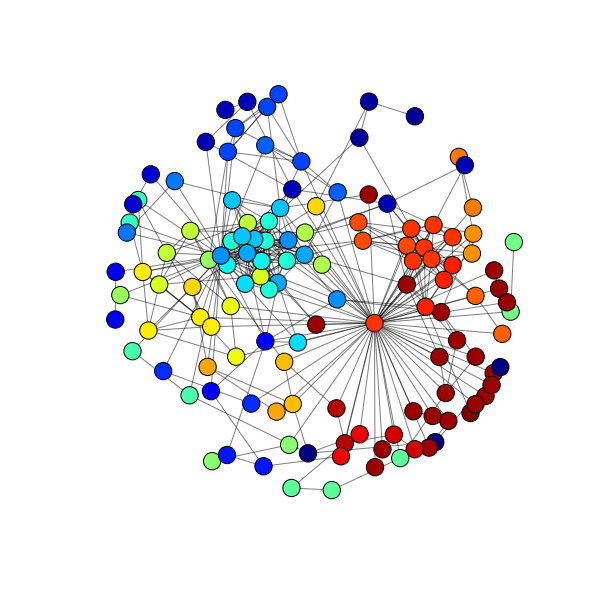

In [9]:
# Visualize the clustering.
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(call_graph)

nx.draw_networkx_nodes(call_graph, pos=pos, node_color=hc_partition.values())
nx.draw_networkx_edges(call_graph, pos=pos, alpha=0.5)
plt.show()

Two remarks are in order with regard to the clustering result obtained. 

The first is that cluster assignment is determined inside our **create_hc** function, specifically the call 

`hierarchy.fcluster(Z,t=t, criterion='inconsistent')`

where t is a threshold (scalar value, t=1.15 in our case) and criterion is the criterion used in forming flat clusters (of which there are five options, with *inconsistent* the default). We have specified reasonable values for these estimates but typically the user needs to optimize these base on a good understanding of the problem domain and the clustering technique. 

Secondly, the visualization of our clusters is not perfect because of the constraints imposed by the node positioning layout algorithm. Unfortunately, NetworkX does not  provide ideal visualization tools to improve the graph display. However, the correct interpretation is that nodes with close or similar color belong to the same cluster (despite the poor reflection of this in the visualization).

The dendrogram corresponding to the above illustrated partitioned graph is obtained as follows:

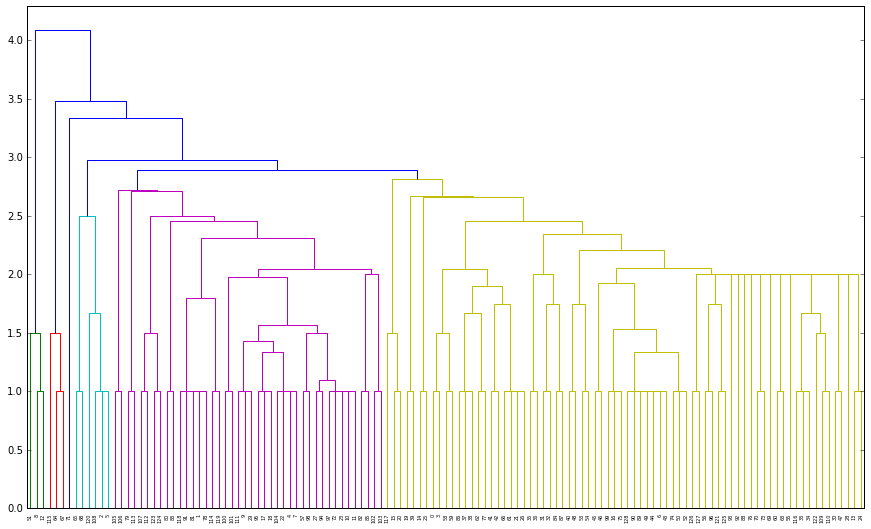

In [10]:
hierarchy.dendrogram(Z)
plt.show()

This dendrogram can help explain what happens as a result of the agglomerative method of hierarchical clustering. Starting at the bottom-most level, each node is assigned its own cluster. The closest pair of nodes (according to a distance function) are then merged into a new cluster. The distance matrix is recomputed, treating the merged cluster as an individual node. This process is repeated until the entire network has been merged into a single large cluster, which the top level in the dendrogram above represents. You can now understand why this method is agglomerative.

The linkage function is used to determine the distance between a cluster and a node, or between two clusters, using the following possibilities:

1. Single: merge two clusters with the smallest minimum pairwise distance.
2. Average: merge two clusters with the smallest average pairwise distance.
3. Maximum or complete: merge the two clusters with the smallest maximum pairwise distance.

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions

> 1. How many clusters are obtained after the final step of agglomerative clustering before post-processing? 
> 2. Based on your answer above, would you consider agglomerative clustering a 'top down' approach or a 'bottom up' approach?.
> 3. Which of the three linkage functions listed above (i.e. single, average, maximum/complete) above do you think is likely to be most sensitive to outliers? **Hint**: See this [link](http://nlp.stanford.edu/IR-book/html/htmledition/single-link-and-complete-link-clustering-1.html)

Your markdown answer here.

1. One.
2. 'bottom up' approach.
3. Maximum or complete.


<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>
> **Exercise complete**:

### 2.1 Block models

A graph network can be simplified using block models, in which all nodes in a cluster are merged into a single node. Relationships between original nodes become aggregated into relationships between blocks or communities.

You can use results from your hierarchical clustering to create the block model. NetworkX has a function to build a block model which accepts the graph model and cluster information from the hierarchical clustering, as illustrated below.

In [11]:
M=nx.blockmodel(call_graph,blk_clusters.values())

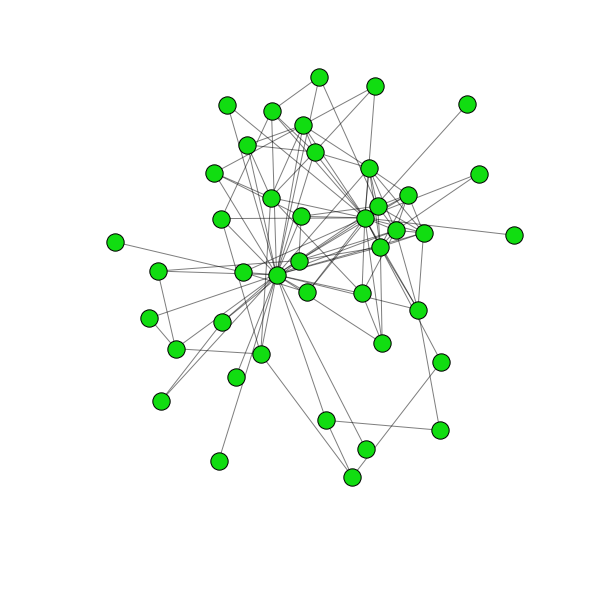

In [12]:
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(M)

nx.draw_networkx_nodes(M, pos=pos, node_color='#11DD11')
nx.draw_networkx_edges(M, pos=pos, alpha=0.5)
plt.show()

<br>
<div class="alert alert-info">
<b>Exercise 2 [Advanced exercise for bonus marks] Start.</b>
</div>

### Instructions

> Load the SMS graph adjacency matrix from what you created in previous exercises into a variable called SMS_graph.

> 1. Run hierarchical clustering using a default argument setting on SMS_graph, and assign the outputs to: Z_1, membership_1, and blk_clusters_1.
> 2. Initialize an empty dict variable: partition_1.
> 3. Assign corresponding items in the list membership_1 to the dict partition_1.
> 4. Draw the SMS_graph with cluster information superimposed to reveal communities in the graph.
> 5. Plot the corresponding dendrogram.

In [13]:
# Your code here.
SMS_adjmatrix = pd.read_csv('./sms.adjmatrix', index_col=0)
SMS_graph     = nx.from_numpy_matrix(SMS_adjmatrix.as_matrix())

In [14]:
# Run hierarchical clustering using a default argument setting on SMS_graph.
# Assign the outputs to: Z_1, membership_1, and blk_clusters_1.
Z_1, membership_1, blk_clusters_1 = create_hc(SMS_graph) 

In [15]:
# Map membership values to a dictionary variable.
# Initialize an empty dict variable: partition_1.
partition_1 = {}

# Assign corresponding items in the list membership_1 to the dict partition_1.
i = 0
for i in range(len(membership_1)):
    partition_1[i]=membership_1[i]

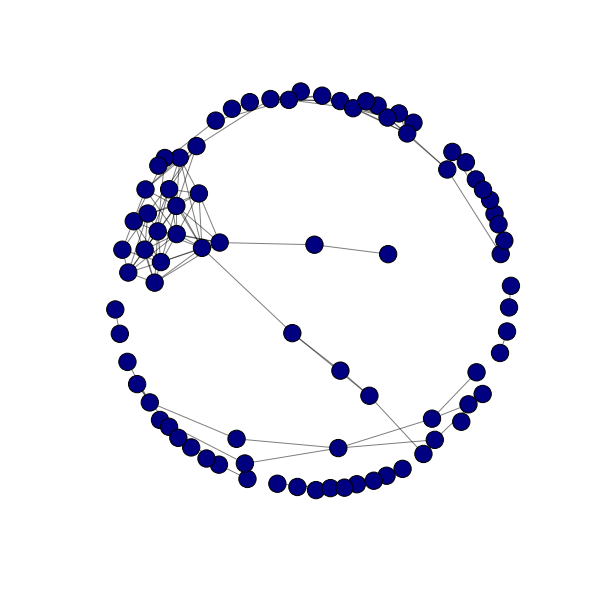

In [16]:
# Draw the SMS_graph with cluster information superimposed to reveal communities in the graph.
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(SMS_graph)

nx.draw_networkx_nodes(SMS_graph, pos=pos, node_color=partition_1.values())
nx.draw_networkx_edges(SMS_graph, pos=pos, alpha=0.5)
plt.show()

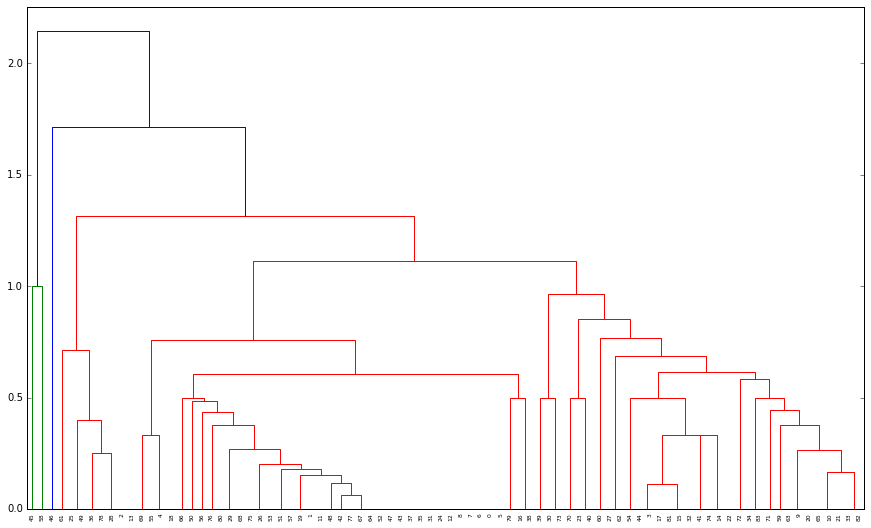

In [17]:
# Plot the corresponding dendrogram.
hierarchy.dendrogram(Z_1)
plt.show()

<br>
<div class="alert alert-info">
<b>Exercise 2 End.</b>
</div>
> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

<br>
<div class="alert alert-info">
<b>Exercise 3 [Advanced exercise for bonus marks] Start.</b>
</div>

### Instructions

> 1. Repeat Exercise 2, using single link distance measure.
> 2. How do the uses of single and average distance measures compare? A qualitative description is sufficient.

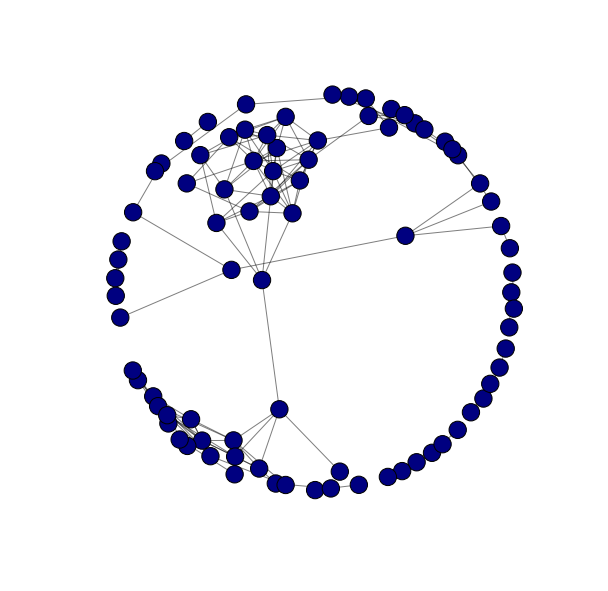

In [20]:
# Your code here.
Z_2, membership_2, blk_clusters_2 = create_hc(SMS_graph, linkage='single')

# Initialize an empty dict variable: partition_1.
partition_2 = {}

# Assign corresponding items in the list membership_1 to the dict partition_1.
i = 0
for i in range(len(membership_2)):
    partition_2[i]=membership_2[i]
    
# Draw the SMS_graph with cluster information superimposed to reveal communities in the graph.
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(SMS_graph)

nx.draw_networkx_nodes(SMS_graph, pos=pos, node_color=partition_2.values())
nx.draw_networkx_edges(SMS_graph, pos=pos, alpha=0.5)
plt.show()

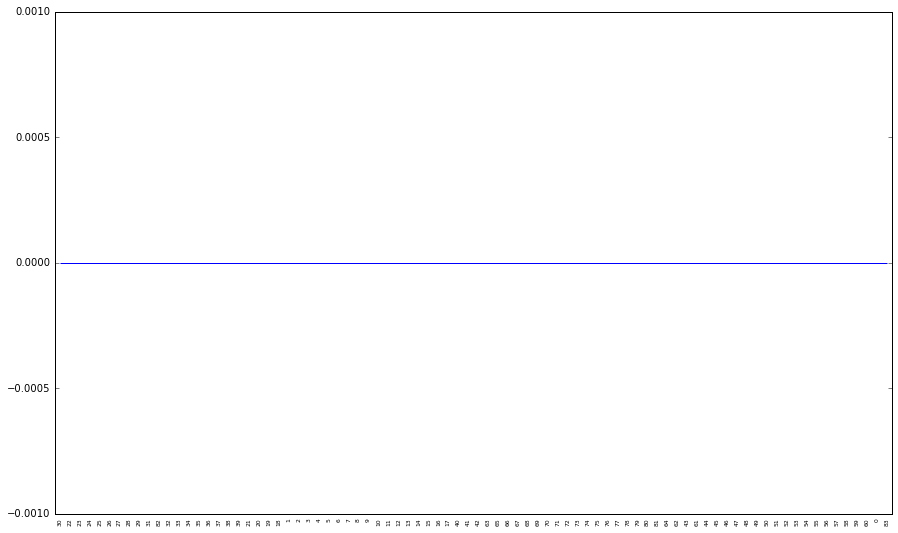

In [23]:
# Plot the corresponding dendrogram.
hierarchy.dendrogram(Z_2)
plt.show()

 The uses of single and average distance measures are similar to the comparison of single and max distance measures. Average distance measures take both local and global clusters into account. The distance of clusters of average measures are further than the distance of single distance measures.

<br>
<div class="alert alert-info">
<b>Exercise 3 End.</b>
</div>
> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 3. Community detection

***The Louvain Modularity Maximization Approach.***

The Louvain method is one of the most widely-used methods for detecting communities in large networks. It was developed by a team of researchers at the the Université catholique de Louvain. It can unveil hierarchies of communities, and allows you to zoom within communities to discover sub-communities, sub-sub-communities, and so forth. The modularity QQ quantifies how good a "community" or partition is, and is defined as:

$$Q_c =\frac{1}{2m}\sum _{(ij)} \left [ A_{ij}-\frac{k_ik_j}{2m} \right] \delta(c_i, c_j)$$

The higher the $Q_c$ of a community is, the better the partition is.

The Louvain method is a greedy optimization method that attempts to optimize the "modularity" of a partition of the network via two steps:

1. Locally optimize the modularity to identify "small" communities.
2. Aggregate nodes belonging to the same community, and create a new network with aggregated nodes as individual nodes.

Steps 1 and 2 are then repeated until a maximum of modularity results in a hierarchy of communities being produced.

Now you have the opportunity to identify communities in the “Family & Friends” call data set. First, compute the best partition.

In [24]:
louvain_partition = community.best_partition(call_graph)

Then you can identify and label the communities similarly to what you did when using agglomerative hierarchical clustering.

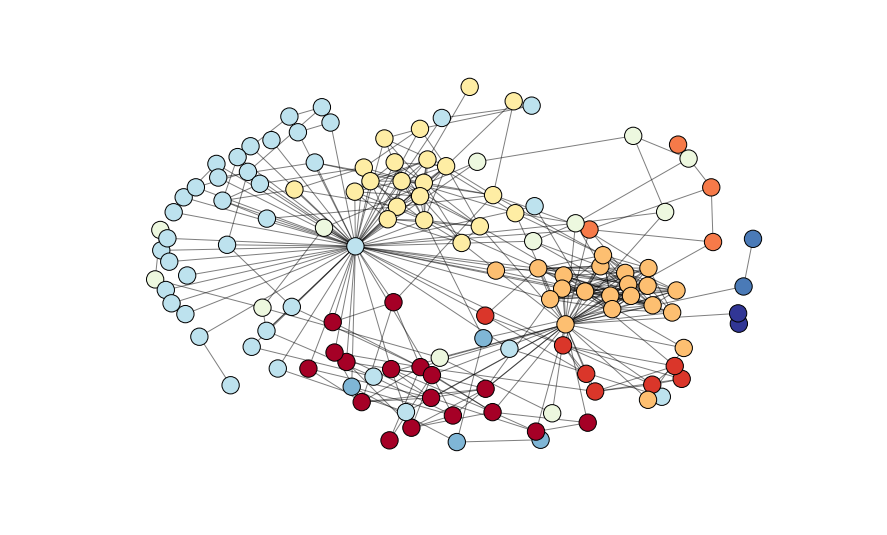

In [25]:
pos = nx.spring_layout(call_graph)
nx.draw_networkx_nodes(call_graph, pos, cmap=plt.cm.RdYlBu, node_color=louvain_partition.values())
nx.draw_networkx_edges(call_graph, pos, alpha=0.5)
plt.axis('off')
plt.show()

As remarked above, the visualization of our clusters is not perfect because of the constraints imposed by the node positioning layout algorithm. The correct interpretation is that nodes with close or similar color belong to the same cluster (despite the poor reflection of this in the visualization).

## 4. Spectral graph partitioning

Spectral graph partitioning and clustering is based on the spectrum — the eigenvalues and associated eigenvectors — of the Laplacian matrix corresponding to a given graph. The approach is mathematically complex but involves performing a $k$-means clustering on a spectral projection of the graph with $k$=2, using an adjacency matrix as the affinity. A schematic illustration of the process is depicted in the figure below.

**Optional**: You can read more about spectral graph processing [here](https://devblogs.nvidia.com/parallelforall/fast-spectral-graph-partitioning-gpus/).

<img src="img\spectral_graph_part.png", width=750, height=550>

Now apply spectral graph partitioning to your call graph and visualize the resulting community structure. You can read more about [Scikit-Learn](http://scikit-learn.org/stable/index.html) and the [Spectral Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) function utilized in this section. Spectral graph partitioning needs input of the number of clusters sought (default setting is 8), and there are various approaches one can take to optimize the final number of clusters depending on problem domain knowledge. Below we use $k=5$

In [26]:
# Create the spectral partition using the spectral clustering function from Scikit-Learn.
spectral_partition = spc(call_adjmatrix.as_matrix(), 5, assign_labels='discretize')

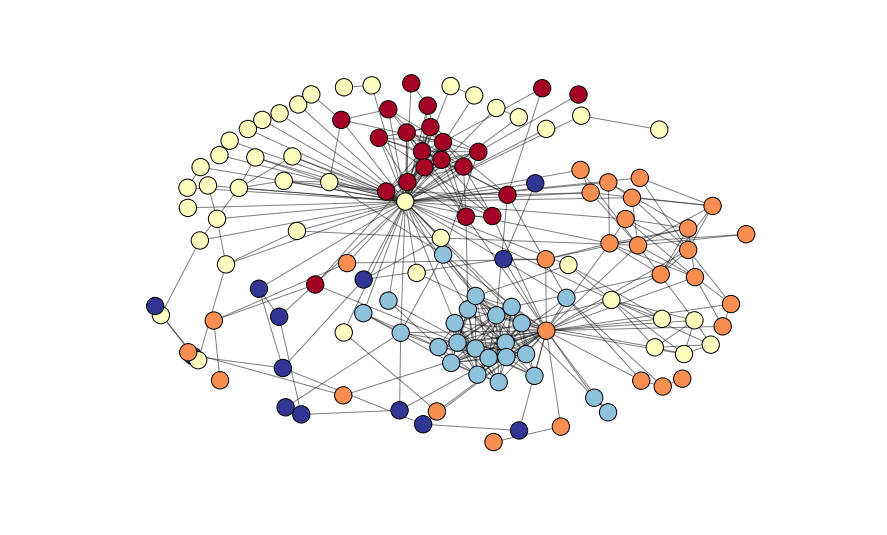

In [27]:
pos = nx.spring_layout(call_graph)
nx.draw_networkx_nodes(call_graph, pos, cmap=plt.cm.RdYlBu, node_color=spectral_partition)
nx.draw_networkx_edges(call_graph, pos, alpha=0.5)
plt.axis('off')
plt.show()

<br>
<div class="alert alert-info">
<b>Exercise 4 [Advanced exercise for bonus marks] Start.</b>
</div>

### Instructions
> 1. Using SMS_graph (H) that you saved from a previous exercise, rerun the above steps and show (visually) the results of running the following approaches:<br>
>   a. Louvain method; and<br>
>   b. Spectral graph partitioning.

> **Note**:

> Interpretation of the results requires knowledge of the clustering techniques not explored in detail here.</font>

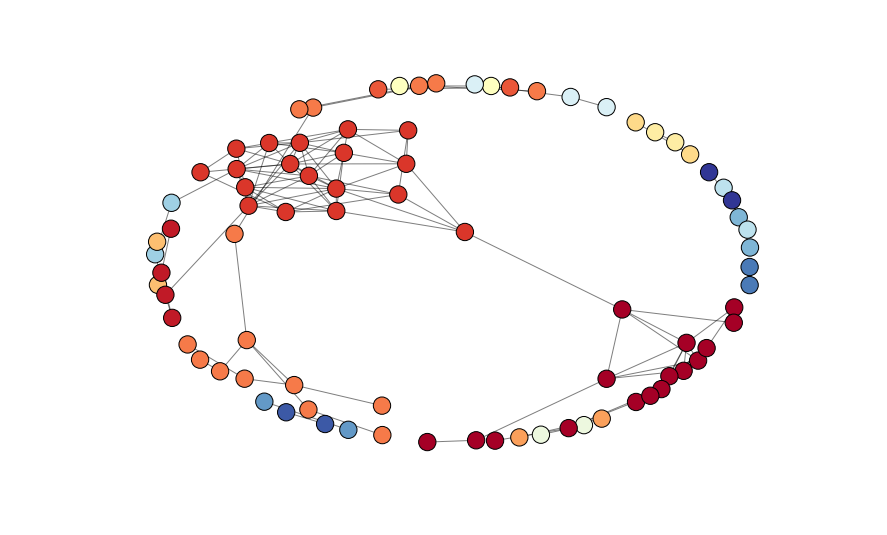

In [28]:
# Your code here.
louvain_partition_1 = community.best_partition(SMS_graph)
pos = nx.spring_layout(SMS_graph)
nx.draw_networkx_nodes(SMS_graph, pos, cmap=plt.cm.RdYlBu, node_color=louvain_partition_1.values())
nx.draw_networkx_edges(SMS_graph, pos, alpha=0.5)
plt.axis('off')
plt.show()

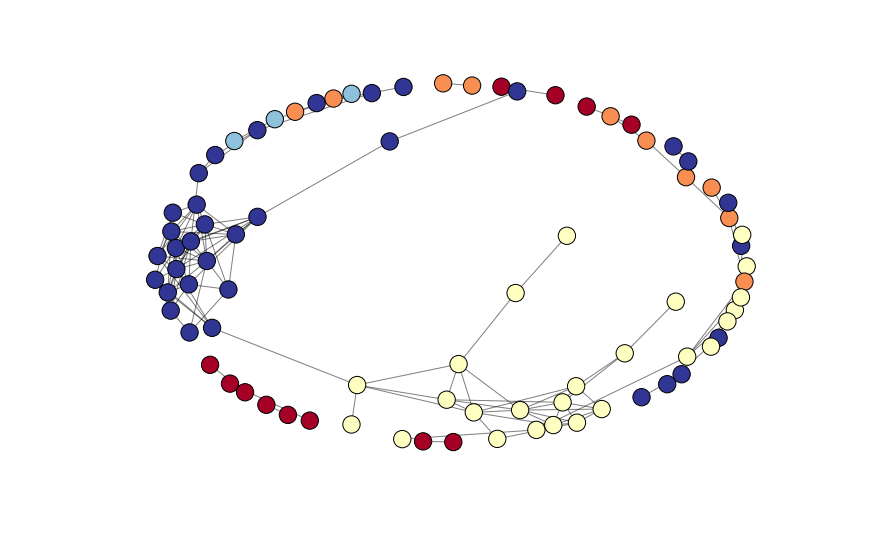

In [30]:
# Create the spectral partition using the spectral clustering function from Scikit-Learn.
spectral_partition_1 = spc(SMS_adjmatrix.as_matrix(), 5, assign_labels='discretize')

pos = nx.spring_layout(SMS_graph)
nx.draw_networkx_nodes(SMS_graph, pos, cmap=plt.cm.RdYlBu, node_color=spectral_partition_1)
nx.draw_networkx_edges(SMS_graph, pos, alpha=0.5)
plt.axis('off')
plt.show()

<br>
<div class="alert alert-info">
<b>Exercise 4 End.</b>
</div>
> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 5. Submit your notebook

Please make sure that you:
- Perform a final "Save and Checkpoint";
- Download a copy of the notebook in ".ipynb" format to your local machine using "File", "Download as", and "IPython Notebook (.ipynb)"; and
- Submit a copy of this file to the online campus.